## Data import

Note:
- cadCAD library designed for simulations of complex systems has been used to backtest the Stoikov's strategy. 
- I took first 30000 rows from df_book and first 100000 rows from df_trades due to limitations of computer power
- The delay parameter impacting the delay between placing new two-sided trades has been set 
to 1000000000 (1 second) due to the fact that it has accelerated the computations
- Other parameters have been kept how they were in the article. However, design of these parameters can improve the performance of the strategy


In [1]:
import os

os.chdir("/Users/slitasov/PycharmProjects/pythonCmf/venv")

In [2]:
from initial_state import *
from policy_functions import *
from state_variables import *

In [3]:
x = pd.to_datetime(df_book['timestamp'])

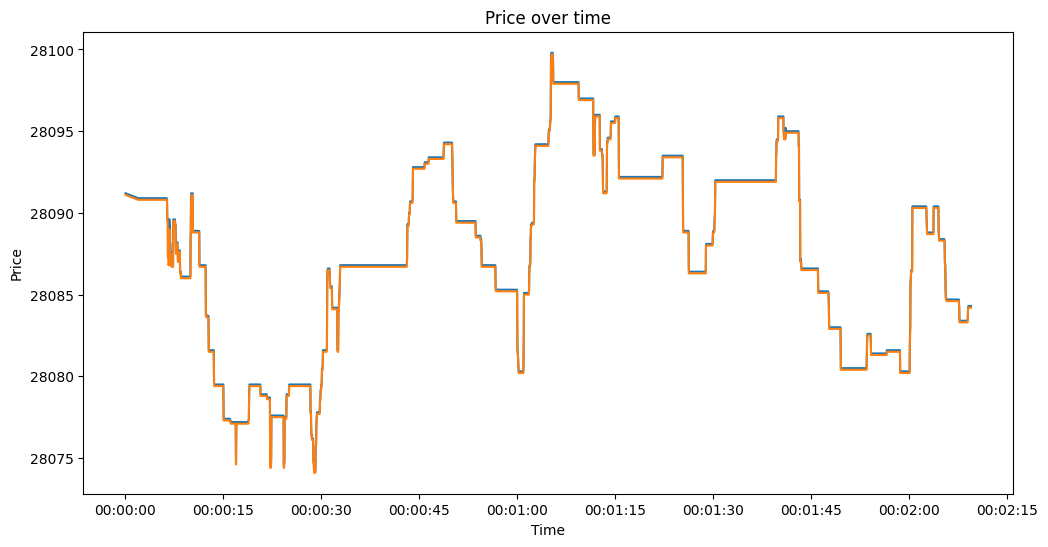

In [4]:
plt.figure(figsize=(12,6))
plt.plot(x, df_book['asks[0].price'])
plt.plot(x, df_book['bids[0].price'])
plt.title('Price over time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [5]:
df_book['spread'] = df_book['asks[0].price'] - df_book['bids[0].price']
df_book['spread'].describe()

count    3000.000000
mean        0.111700
std         0.128629
min         0.100000
25%         0.100000
50%         0.100000
75%         0.100000
max         2.300000
Name: spread, dtype: float64

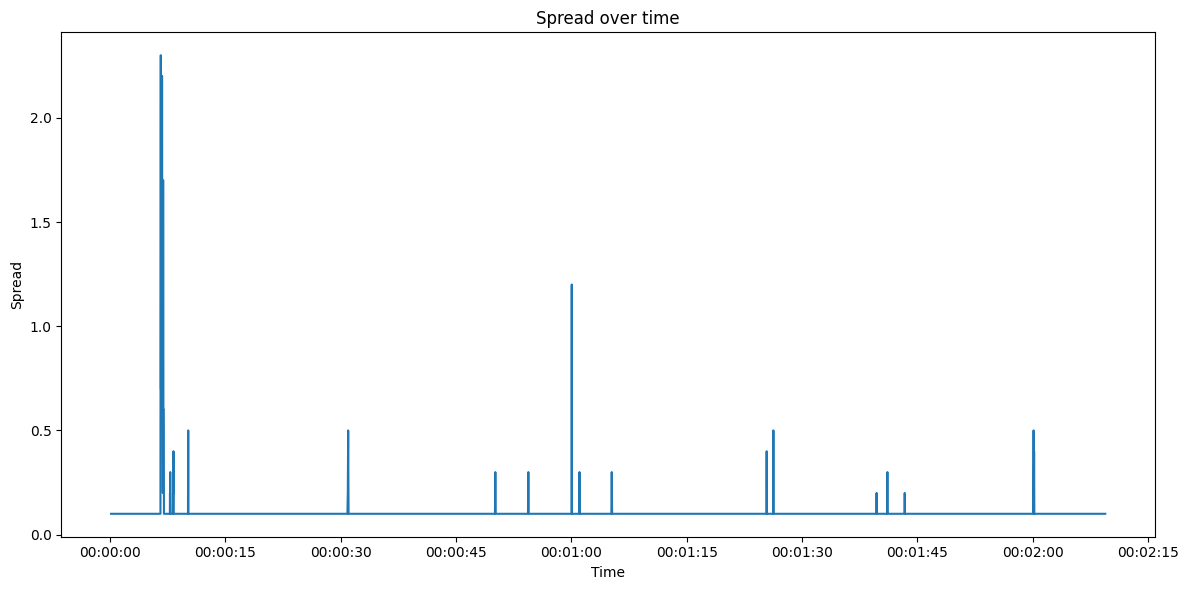

In [6]:
plt.figure(figsize=(12,6))

plt.title('Spread over time')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.plot(x, df_book['spread'])

plt.tight_layout()
plt.show()


In [7]:
# Function to calculate the first n elements in columns 'asks[i].price'
def calculate_bid_depth(row, n):
    return sum(row[f'asks[{i-1}].price'] * row[f'asks[{i-1}].amount'] for i in range(1, n + 1))

def calculate_ask_depth(row, n):
    return sum(row[f'bids[{i-1}].price'] * row[f'bids[{i-1}].amount'] for i in range(1, n + 1))

for n in range(1, 11):
    df_book[f'bid_depth{n-1}'] = df_book.apply(lambda row: calculate_bid_depth(row, n), axis=1)
    df_book[f'ask_depth{n-1}'] = df_book.apply(lambda row: calculate_ask_depth(row, n), axis=1)

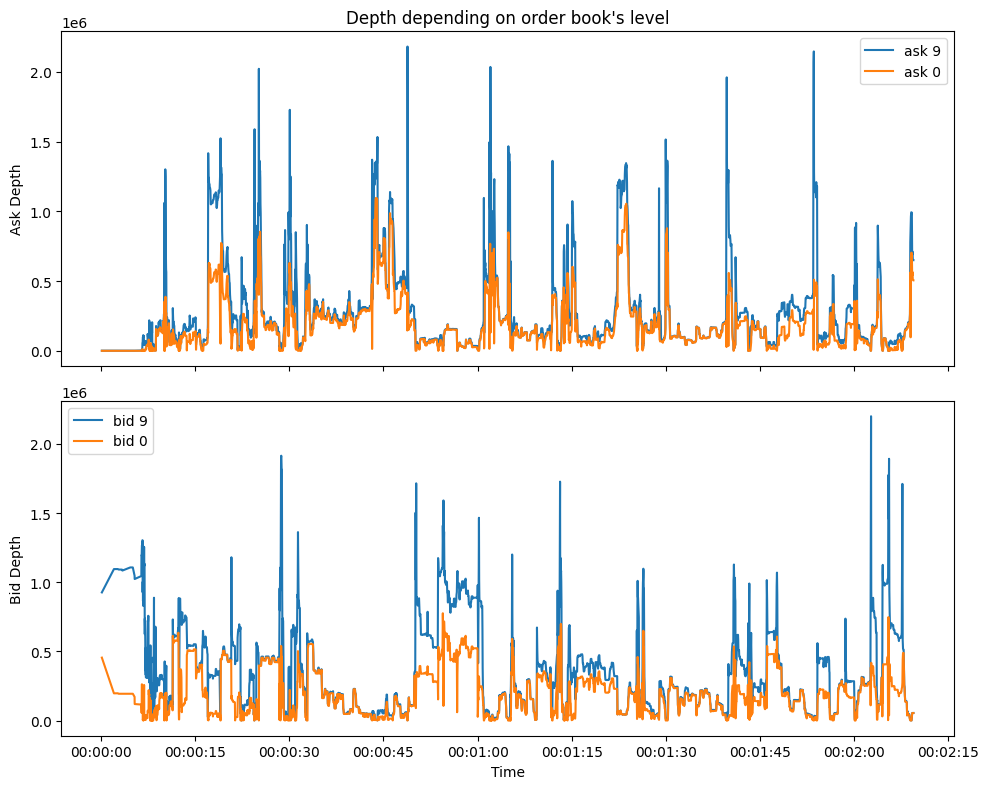

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))

# Plot for asks
ax[0].plot(x, df_book[f'ask_depth9'], label='ask 9')
ax[0].plot(x, df_book[f'ask_depth0'], label='ask 0')
ax[0].set_ylabel('Ask Depth')
ax[0].legend()
ax[0].set_title('Depth depending on order book\'s level')

# Plot for bids
ax[1].plot(x, df_book[f'bid_depth9'], label='bid 9')
ax[1].plot(x, df_book[f'bid_depth0'], label='bid 0')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Bid Depth')
ax[1].legend()

plt.tight_layout()
plt.show()


In [9]:
df_book.drop(columns=['exchange', 'symbol'], inplace=True)

In [10]:
# Depth of order's size
df_depth = df_book.copy()
for i in range(1, 25): 
    size_sum_ask = 0
    size_sum_bids = 0

    for q in range(i+1):
        
        size_sum_ask += df_book[f'asks[{q}].amount']
        size_sum_bids += df_book[f'bids[{q}].amount']
        
    df_depth[f'asks[{i}].amount'] = size_sum_ask 
    df_depth[f'bids[{i}].amount'] = size_sum_bids

df_book = df_depth

## Simulation (Stoikov's strategy)

High level overview: 

1. Place orders
- Take the current state on an Order Book. Calculate reservation prices and other parameters related to placing an order. 
- If (current_time - previous_order_place_time) > delay --> place an order and add it to active_orders

2. Removing orders
- Remove orders in active_orders that are held > hold_time
- For each trade that have been executed between previous state of the OB and current state of the OB check if the size of the order is higher than the depth of each of the active orders. If the size is higher --> execute an order and remove it from active_orders, keep the order otherwise
- Make a final trade to set q equal to 0 and calculate PnL

In [11]:
exec_context = ExecutionContext()
simulation = Executor(exec_context=exec_context, configs=experiment.configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 2999, 11, 1, 11)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (2999, 11, 1, 11)
Execution Method: local_simulations
Execution Mode: single_threaded
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
14

In [12]:
df = pd.DataFrame(raw_result)

In [13]:
df = df[df['substep'] == 3]

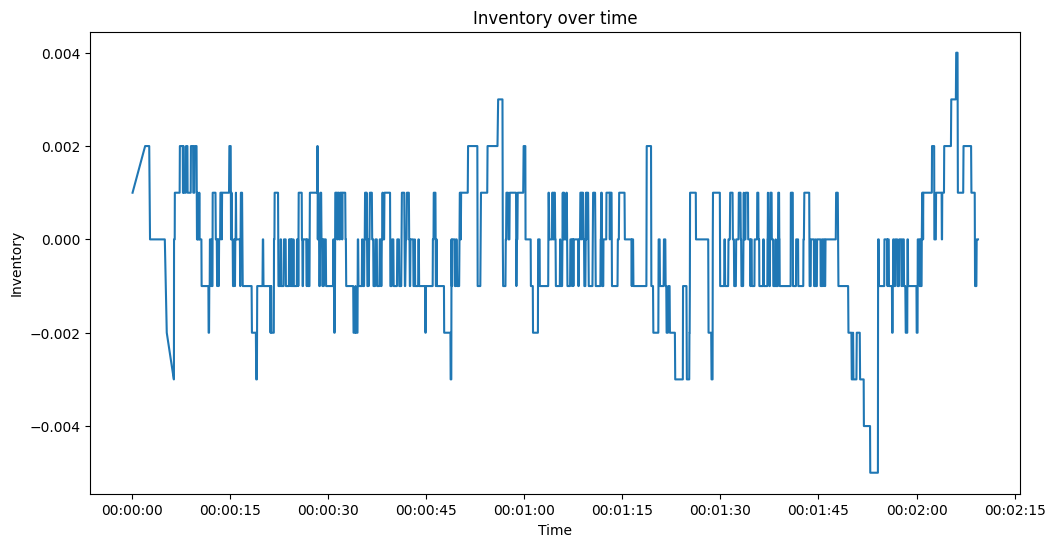

In [14]:
x = x[:len(df_book) - 1]

plt.figure(figsize=(12,6))
plt.title('Inventory over time  (Stoikov"s strategy)')
plt.xlabel('Time')
plt.ylabel('Inventory')
plt.plot(x[:], df['q'])
plt.show()

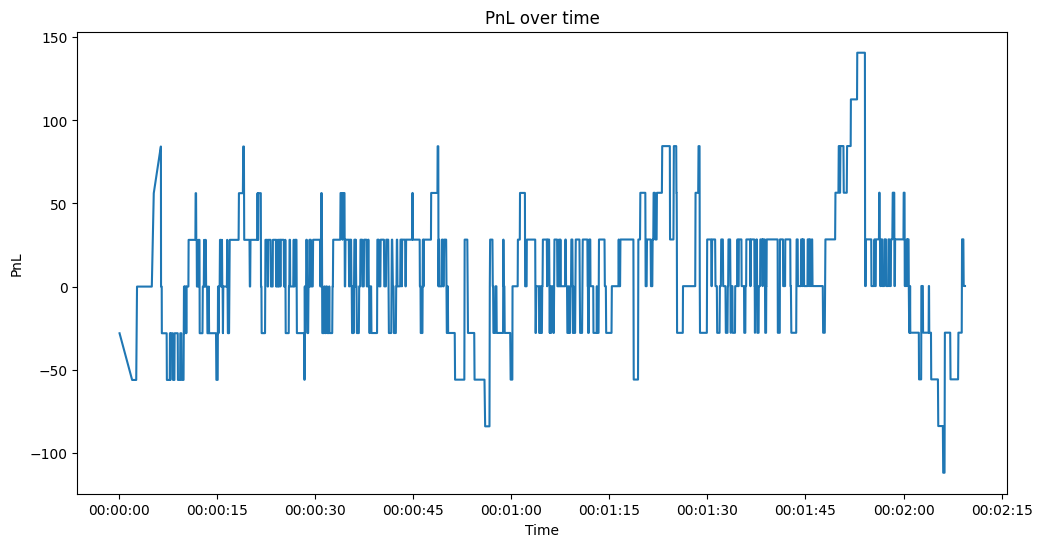

In [15]:
plt.figure(figsize=(12,6))

plt.title('PnL over time (Stoikov"s strategy)')
plt.xlabel('Time')
plt.ylabel('PnL')
plt.plot(x, df['PnL'])
plt.show()

In [16]:
print('Final PnL of basic  strategy:', '$' + df['PnL'].iloc[-1])

Final PnL: 0.3555450357578813


Logic: 

In [31]:
from initial_state import *
from policy_functions_volume_enhanced import *
from state_variables_volume_enhanced import *

In [32]:
del configs[:]

In [33]:
exec_context = ExecutionContext()
simulation = Executor(exec_context=exec_context, configs=experiment.configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 2999, 11, 1, 11)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (2999, 11, 1, 11)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 68.67s


In [34]:
df = pd.DataFrame(raw_result)
df = df[df['substep'] == 3]

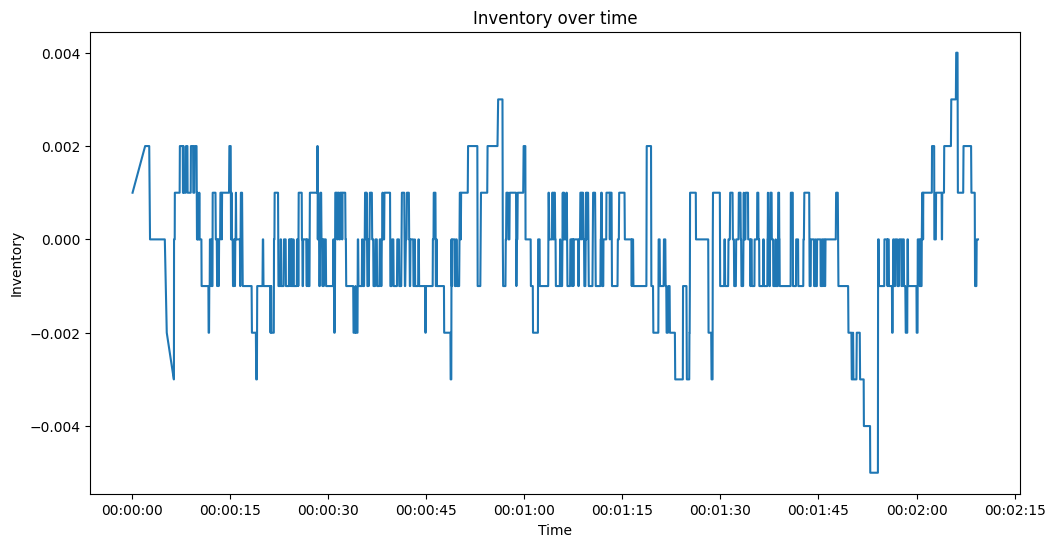

In [35]:
x = x[:len(df_book) - 1]

plt.figure(figsize=(12,6))
plt.title('Inventory over time (Enhanced Stoikov"s strategy)')
plt.xlabel('Time')
plt.ylabel('Inventory')
plt.plot(x[:], df['q'])
plt.show()

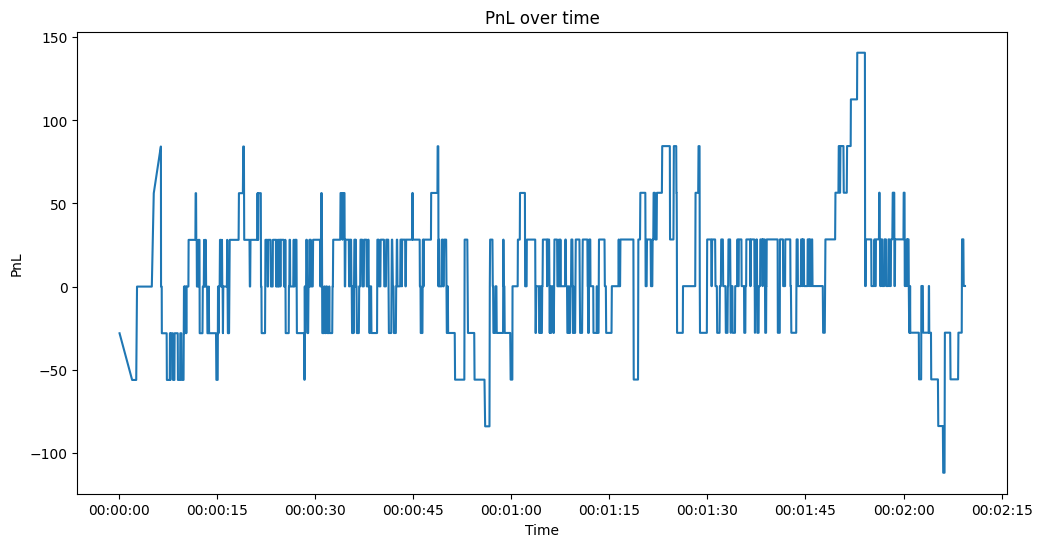

In [36]:
plt.figure(figsize=(12,6))

plt.title('PnL over time (Enhanced Stoikov"s strategy)')
plt.xlabel('Time')
plt.ylabel('PnL')
plt.plot(x, df['PnL'])
plt.show()

In [37]:
print('Final PnL of Enhanced strategy:', '$' +df['PnL'].iloc[-1])

Final PnL: 0.3555450357578813
